# DBScan

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]

In [9]:
def plot_data(data, ax=None):
    if ax is None: _,ax = plt.subplots()
    for group in data:
        ax.scatter(group[:,0], group[:,1], s=1)

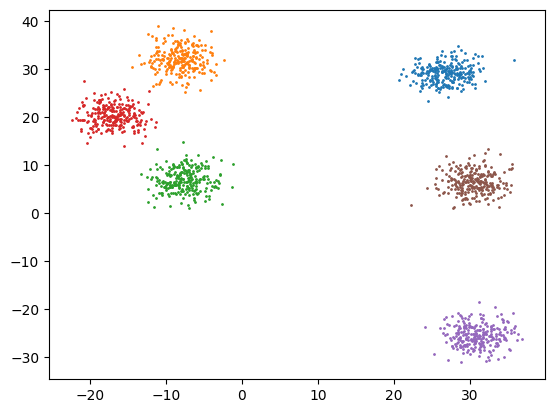

In [10]:
plot_data(slices)

In [11]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [12]:
data[:,0].shape # all xs, [:,1] all ys

torch.Size([1500])

In [13]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

## DBScan Definition

Consider a set of points in some space to be clustered. Let ε be a parameter specifying the radius of a neighborhood with respect to some point. For the purpose of DBSCAN clustering, the points are classified as core points, (directly-) reachable points and outliers, as follows:

- A point p is a core point if at least minPts points are within distance ε of it (including p).
- A point q is directly reachable from p if point q is within distance ε from core point p. Points are only said to be directly reachable from core points.
- A point q is reachable from p if there is a path p1, ..., pn with p1 = p and pn = q, where each pi+1 is directly reachable from pi. Note that this implies that the initial point and all points on the path must be core points, with the possible exception of q.
- All points not reachable from any other point are outliers or noise points.

Now if p is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points. 

A cluster [then] satisfies two properties:

1. All points within the cluster are mutually density-connected.
2. If a point is density-reachable from some point of the cluster, it is part of the cluster as well.

The DBSCAN algorithm can be abstracted into the following steps:

1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.
3. Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

https://en.wikipedia.org/wiki/DBSCAN#Abstract_algorithm

## Non-parallelized implementation

In [14]:
eps = 0.5 # max distance to be considered neighbours
min_pts = 5 # min points

In [15]:
X = data.clone()
x = data[:5]

In [16]:
data[0].shape

torch.Size([2])

In [17]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1) <= eps)

In [18]:
foo = {}
"bar" not in foo

True

In [19]:
for i in torch.nonzero(is_neighbour(x[0], X, eps)).squeeze():
    print(i, X[i])

tensor(0) tensor([26.204, 26.349])
tensor(72) tensor([25.807, 26.060])
tensor(151) tensor([26.459, 26.723])
tensor(182) tensor([26.446, 26.410])
tensor(194) tensor([26.814, 26.671])
tensor(208) tensor([26.085, 25.912])
tensor(215) tensor([26.843, 26.434])
tensor(221) tensor([25.865, 26.078])
tensor(233) tensor([26.895, 26.417])
tensor(239) tensor([25.534, 26.495])


In [20]:
torch.nonzero(is_neighbour(x[0], X, 0.5)).squeeze().tolist()

[0, 72, 151, 182, 194, 208, 215, 221, 233, 239]

In [21]:
is_neighbour(x[0], X, 0.5)

tensor([ True, False, False,  ..., False, False, False])

In [22]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1).sqrt() <= eps)

def build_groups(group_data, group_count, data_length):
    groups = []
    
    for i in range(1, group_count):
        group_indexes = list(filter(lambda key: group_data[key] == i, group_data.keys()))
        group = X[group_indexes]
        groups.append(group)

    noise_indexes = list(filter(lambda key: key not in group_data or group_data[key] == "noise", list(range(0, data_length)))) # only expecting "not in" scenario if called as callback

    if len(noise_indexes) > 0:
        noise = X[noise_indexes]
        groups.append(noise)

    return groups

def dbscan(data, eps=0.5, min_pts=5, callback=lambda point_to_group, group_count, data_length: None):
    n = len(data)
    X = data.clone()

    point_to_group = {}
    group_label = 0
    
    for i in range(0, n):
        if i in point_to_group:
            continue
        
        datum = X[i]

        is_core_point = is_neighbour(datum, X, eps).sum() - 1 >= min_pts # subtract one as datapoint itself will also register as neighbour but shouldn't be counted
        
        if not is_core_point:
            point_to_group[i] = "noise"
            continue

        group_label = group_label + 1
        
        point_to_group[i] = group_label

        neighbour_indexes = torch.nonzero(is_neighbour(datum, X, eps)).squeeze().tolist()

        for ni in neighbour_indexes:
            if ni in point_to_group and point_to_group[ni] == "noise":
                point_to_group[ni] = group_label

            if ni in point_to_group:
                continue

            point_to_group[ni] = group_label

            is_core_point = is_neighbour(X[ni], X, eps).sum() - 1 >= min_pts

            if is_core_point:
                recursed_neighbour_indexes = torch.nonzero(is_neighbour(X[ni], X, eps)).squeeze().tolist()
                recursed_neighbour_indexes = list(set(recursed_neighbour_indexes).difference(set(neighbour_indexes)))
    
                neighbour_indexes.extend(recursed_neighbour_indexes)

        callback(point_to_group, group_label+1, n)

    return build_groups(point_to_group, group_label+1, n)

In [23]:
clusters = dbscan(X, eps=0.5, min_pts=5)
clusters[0][:5]

tensor([[26.204, 26.349],
        [25.807, 26.060],
        [26.459, 26.723],
        [26.446, 26.410],
        [26.085, 25.912]])

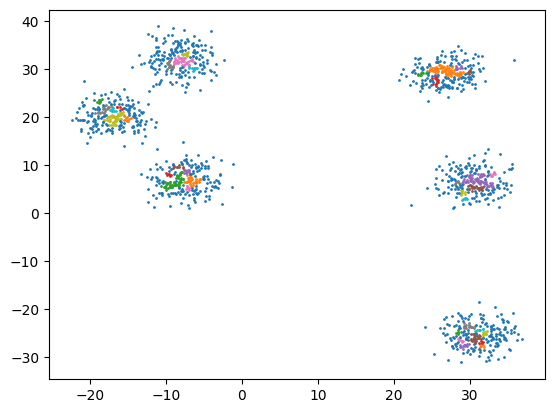

In [24]:
plot_data(clusters)

## Animation

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [26]:
intermediary_groups = []

def callback(group_data, group_count, data_length):
    intermediary_groups.append(build_groups(group_data, group_count, data_length))

dbscan(X, eps=0.5, min_pts=5, callback=callback)

final_group_len = len(intermediary_groups[-1])
group_count = len(intermediary_groups)

In [27]:
group_iterator = iter(intermediary_groups)

def plot_fn(d):
    ax.clear()
    
    next_data = next(group_iterator)
    group_len = len(next_data)

    noise_group = next_data.pop()

    next_data.extend([torch.empty(0, 2) for _ in range(final_group_len-group_len)]) # pad to keep group count and animation colours consistent
    
    next_data.append(noise_group)

    return plot_data(next_data, ax)

In [28]:
torch.empty(0, 2), torch.empty(0, 2)[:,0], torch.empty(0, 2)[:,1]

(tensor([], size=(0, 2)), tensor([]), tensor([]))

In [ ]:
# create your own animation
fig,ax = plt.subplots()

ani = FuncAnimation(fig, plot_fn, frames=group_count-1, interval=1000, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
%timeit -n 5 _= dbscan(X, eps=0.5, min_pts=5)

## Modifying for GPU parallelizability

In [ ]:
import torch.nn as nn

In [ ]:
X = data.clone()
x = data[:5]

In [ ]:
X.shape, x.shape, x[:,None,:].shape, X[None].shape, (x[:,None,:]-X[None]).shape

In [ ]:
(((x[:,None,:]-X[None])**2).sum(dim=2).sqrt() <= eps).sum(dim=1) > 5

In [ ]:
def euclidean_distance(points, other_points):
    return torch.einsum('ijk,ijk->ij', points-other_points, points-other_points).sqrt()

In [ ]:
def is_core_point(batch, other_points, eps=2, min_neighbours=5):
    return (euclidean_distance(batch[:,None,:], other_points[None]) <= eps).sum(dim=1) >= min_neighbours

In [ ]:
s = slice(0, 500)

In [ ]:
X[s].shape, X[s][is_core_point(X[s], X)].shape

In [ ]:
labels = -torch.ones(1500, dtype=torch.int32)
labels

In [ ]:
n = len(data)
X = data.clone()
labels = -torch.ones(n)

core_point_mask = is_core_point(X, other_points=X, eps=eps, min_neighbours=min_pts)
core_points = X[core_point_mask]
noise = X[~core_point_mask]

core_points.shape, noise.shape

In [ ]:
def connections(points, other_points):
    differences = points[:,None,:] - other_points[None]
    return torch.einsum('ijk,ijk->ij', differences, differences).sqrt()

In [ ]:
connections(core_points, core_points)

In [ ]:
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

In [ ]:
adjacency_graph = connections(core_points, core_points) <= eps
adjacency_graph

In [ ]:
torch.allclose(adjacency_graph, adjacency_graph.T)

In [ ]:
labels_tensor = torch.tensor(labels)
sorted_indices = torch.argsort(labels_tensor)
sorted_labels = labels_tensor[sorted_indices]

unique_labels, counts = torch.unique(sorted_labels, return_counts=True)
index_groups = torch.split(sorted_indices, counts.tolist())

index_groups[:10]

In [ ]:
_,labels = connected_components(adjacency_graph, directed=False)
labels[:20]

In [ ]:
edge_analysis = connections(noise, core_points)
core_points.shape, noise.shape, edge_analysis.shape

In [ ]:
edge_adjacency = (edge_analysis <= eps).int()
edge_adjacency

In [ ]:
edges_and_noise = torch.where(
    edge_adjacency.any(dim=1),  # Check if any column matches in each row
    edge_adjacency.argmax(dim=1),  # Get index of first True
    torch.tensor(-1)  # Set to -1 if no match
)
edges_and_noise[:10]

In [ ]:
noise_mask = edges_and_noise == -1
noise[noise_mask].shape

In [ ]:
mask = torch.isin(edges_and_noise, index_groups[0])
noise[mask][:10]

In [ ]:
def euclidean_distances(points, other_points):
    differences = points[:,None,:] - other_points[None]
    return torch.einsum('ijk,ijk->ij', differences, differences).sqrt()

In [ ]:
def is_core_point(batch, other_points, eps, min_neighbours):
    return (euclidean_distances(batch, other_points) <= eps).sum(dim=1) - 1 >= min_neighbours

In [ ]:
def connected_component_groups(core_points, eps):
    adjacency_graph = euclidean_distances(core_points, core_points) <= eps
    
    _,labels = connected_components(csr_matrix(adjacency_graph), directed=False)
    labels_tensor = torch.tensor(labels)
    sorted_indices = torch.argsort(labels_tensor)
    sorted_labels = labels_tensor[sorted_indices]
    
    unique_labels, counts = torch.unique(sorted_labels, return_counts=True)
    
    return torch.split(sorted_indices, counts.tolist())

In [ ]:
def edge_links_to_core_points(noise, core_points, eps):
    distances = euclidean_distances(noise, core_points)
    is_edge = (distances <= eps).int()

    return torch.where(
        is_edge.any(dim=1),
        is_edge.argmax(dim=1),
        torch.tensor(-1)
    )

In [ ]:
def dbscan_parallelized(data, eps=0.5, min_pts=5): # Not sure how to support batching
    n = len(data)
    X = data.clone()
    
    core_point_mask = is_core_point(X, other_points=X, eps=eps, min_neighbours=min_pts)
    
    core_points = X[core_point_mask]
    non_core_points = X[~core_point_mask]

    ccgroups = connected_component_groups(core_points, eps)
    edge_links = edge_links_to_core_points(non_core_points, core_points, eps)

    result = []

    for ccgroup in ccgroups: # Not sure how to avoid for loop for tensors of uneven lengths
        result_group = core_points[ccgroup]
        
        edge_match_mask = torch.isin(edge_links, ccgroup)
        edge_matches = non_core_points[edge_match_mask]

        result.append(torch.cat([result_group, edge_matches]))
         
    noise_mask = edge_links == -1
    result.append(non_core_points[noise_mask])
    
    return result

In [ ]:
parallelized_clusters = dbscan_parallelized(X, eps=0.5, min_pts=5)
parallelized_clusters[0][:5]

In [ ]:
len(clusters), len(parallelized_clusters)

In [ ]:
plot_data(parallelized_clusters)

In [ ]:
plot_data(clusters)

In [ ]:
%timeit -n 5 _= dbscan_parallelized(X, eps=0.5, min_pts=5)

In [ ]:
%timeit -n 5 _= dbscan(X, eps=0.5, min_pts=5)